# Global Modelling
This workbook is focused around the task:
- Modelling Oslo's Public Transit Network as a Layered Graph
- Applying Dinic's algorithm for finding max-flow
- Categorizing Sentrality and general inspection of data

## Step 0 - Imports & Data Loading

In [37]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

edges_path = "edges_GTFS.csv"
stops_path = "nodes_GTFS.csv"

edges = pd.read_csv(edges_path) 
stops = pd.read_csv(stops_path)

display(edges.head()) 
display(stops.head())
print(f"Edges shape: {edges.shape} | Nodes/Stops shape: {stops.shape}")
print("Unique modes in edges:", edges["mode"].unique())


,from,to,lineId,lineCode,mode,authority,travelTimeSec
0,NSR:Quay:7693,NSR:Quay:7791,RUT:Line:21,21,bus,Ruter,60.0
1,NSR:Quay:7791,NSR:Quay:7747,RUT:Line:21,21,bus,Ruter,120.0
2,NSR:Quay:7747,NSR:Quay:11474,RUT:Line:21,21,bus,Ruter,120.0
3,NSR:Quay:11474,NSR:Quay:8226,RUT:Line:21,21,bus,Ruter,60.0
4,NSR:Quay:8226,NSR:Quay:111170,RUT:Line:21,21,bus,Ruter,60.0


,id,stopPlaceId,name,lat,lon,modes,stopType
0,NSR:Quay:7693,NSR:Quay:7693,Tjuvholmen,59.909941,10.722100,bus,bus
1,NSR:Quay:7791,NSR:Quay:7791,Observatoriegata,59.912938,10.719789,bus,bus
2,NSR:Quay:7747,NSR:Quay:7747,Solli,59.915259,10.717343,bus,bus
3,NSR:Quay:11474,NSR:Quay:11474,Riddervolds plass,59.918324,10.718966,bus,bus
4,NSR:Quay:8226,NSR:Quay:8226,Uranienborgveien,59.921100,10.722552,bus,bus


Edges shape: (10655, 7) | Nodes/Stops shape: (4239, 7)
Unique modes in edges: ['bus' 'rail' 'tram' 'water']


## Step 1: Modelling Nodes and Edges
Before modifying the dataset further, a simple visualization was made to verify the usability of the data

In [29]:
#Using Di graph since edges have directions
G = nx.DiGraph()

#Looping through all nodes
for _, row in stops.iterrows():
    node_id = row["id"]
    G.add_node(
        node_id,
        stopPlaceId=row.get("stopPlaceId"),
        name=row.get("name"),
        lat=row.get("lat"),
        lon=row.get("lon"),
        modes=row.get("modes"),
        stopType=row.get("stopType"),
    )

#looping through all edges
for _, row in edges.iterrows():
    u = row["from"]
    v = row["to"]
    
    travel_time = row.get("travelTimeSec", None)    
    capacity = 1 #Setting a temp 1 value here, as we'll be defining this later
    
    G.add_edge(
        u,
        v,
        lineId=row.get("lineId"),
        lineCode=row.get("lineCode"),
        mode=row.get("mode"),
        authority=row.get("authority"),
        travelTimeSec=travel_time,
        capacity=capacity,
    )

#Printing out meta-data
print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())

Number of nodes: 4239
Number of edges: 5406


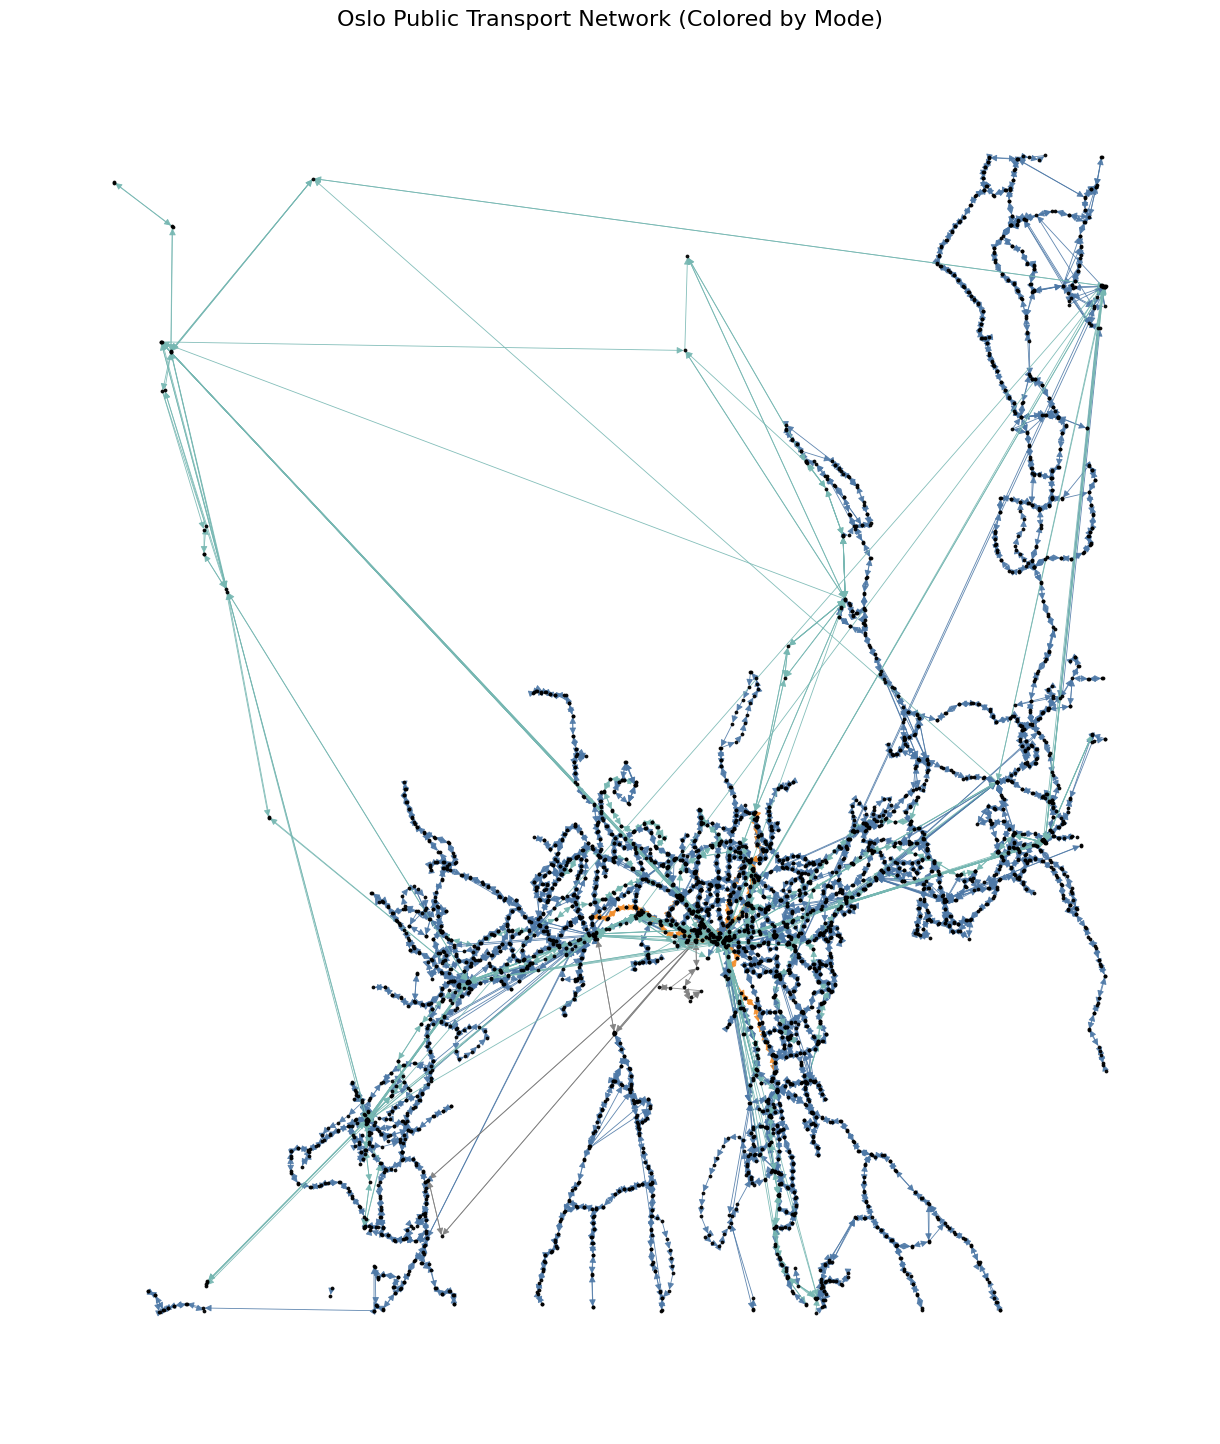

In [32]:

# Defining Mode Colors to differentiate between modes in Graph
mode_colors = {
    "bus": "#4e79a7",
    "tram": "#f28e2c",
    "rail": "#76b7b2",
    "water": "#59a14f",
}

edge_colors = [
    mode_colors.get(data["mode"], "gray") 
    for _, _, data in G.edges(data=True)
]

plt.figure(figsize=(12, 14))
nx.draw(
    G,
    pos,
    node_size=3,
    node_color="black",
    edge_color=edge_colors,
    width=0.6,
    alpha=0.9,
    with_labels=False
)

plt.title("Oslo Public Transport Network (Colored by Mode)", fontsize=16)
plt.axis("off")
plt.show()


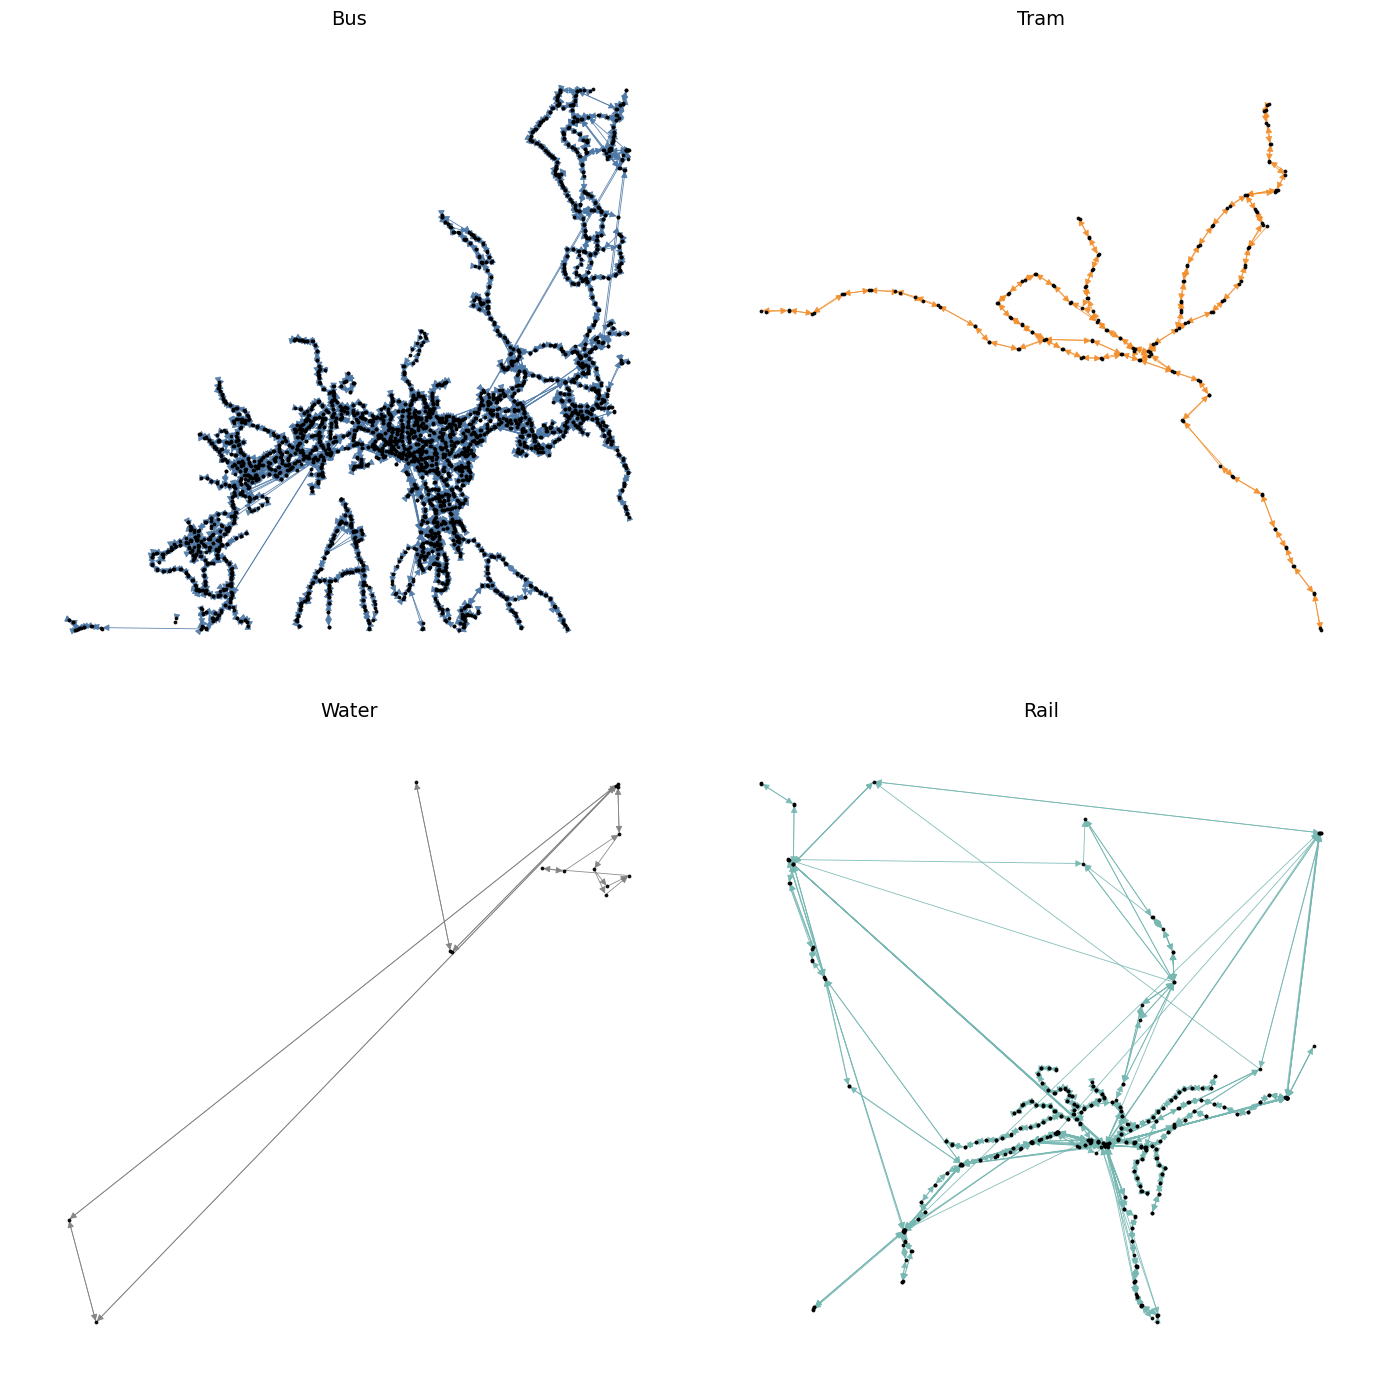

In [38]:
# Section 3: Plot each transport mode separately in 4 subplots (nodes & edges per mode only)

modes = ["bus", "tram", "water", "rail"]

fig, axs = plt.subplots(2, 2, figsize=(14, 14))

for ax, mode in zip(axs.flat, modes):
    ax.set_title(mode.capitalize(), fontsize=14)

    # Edges for this mode
    edges_of_mode = [
        (u, v) for u, v, data in G.edges(data=True)
        if data.get("mode") == mode
    ]

    # Nodes that appear in those edges
    nodes_of_mode = set()
    for u, v in edges_of_mode:
        nodes_of_mode.add(u)
        nodes_of_mode.add(v)

    # Color for this mode's edges
    edge_colors = [mode_colors.get(mode, "gray")] * len(edges_of_mode)

    # Draw only this mode's subgraph
    nx.draw(
        G,
        pos,
        ax=ax,
        with_labels=False,
        nodelist=list(nodes_of_mode),
        edgelist=edges_of_mode,
        node_size=3,
        node_color="black",
        edge_color=edge_colors,
        width=0.6,
        alpha=0.9
    )

    ax.axis("off")

plt.tight_layout()
plt.show()
